<a href="https://colab.research.google.com/github/kdidi99/ml_heidelberg/blob/main/ex5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 5

Team members:

*   Rudolf Braun 
*   Jannik Schacht
*   Kieran Didi

# 5.1 Constructing the matrix X

In [69]:
import numpy as np
import scipy
from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt

In [15]:
def construct_X(M, alphas, Np=None):
    # convert alpha from degree to radian
    alphas = np.array(alphas)*np.pi/180
    if not Np: # set Np, if not already defined
        Np = int(M*2**0.5) + 1
    D = M**2
    N0 = len(alphas)
    N = N0*Np
    s0 = M/2 # offset to centralize the points
    
    Cgrid = np.mgrid[0:M,0:M] # grid to generate the indizes a_j and b_j
    C = np.array([Cgrid[1].flatten()-s0, Cgrid[0].flatten()-s0]) # indizes a_j , b_j centralized
    n = np.array([np.cos(alphas), np.sin(alphas)]) # normal vector of the sensor
    p = np.transpose(C).dot(n) # projection of the distance on the sensor
    
    # the position of the bin where the projection lies is calculated as float...
    # ... to get the next bin below (round down) and above (round up / round down and add 1)
    # the term np.mgrid[0:D,0:N0][1]*Np corresponds to N_p*i_0, so we get the index i = i_p + N_p*i_0
    Pos = np.transpose(p*Np/M/2**0.5+Np/2 + np.mgrid[0:D,0:N0][1]*Np).flatten()
    
    posdown = Pos.astype(int) # positions of the next lower bins
    weightsdown = 1-Pos%1 # the weight is 1-distance
    posup = posdown+1 # positions of the next higher bins
    weightsup = Pos%1 # the weights add up to 1
    
    i_indices = np.array([*posdown, *posup]) # indices of the sensor bins
    j_indices = np.array(list(range(D))*N0*2) # due to the construction of i_indices the j_indices become rather simple
    weights = np.array([*weightsdown, *weightsup]) # corresponding weights
    
    X = scipy.sparse.coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype = np.float32)
    return X

Corrections:

- Np calculation: Added +1 to round up

In [18]:
X = construct_X(M = 10, alphas = [-33, 1, 42], Np = 15)
print(X.shape)

(45, 100)


Matrices equal: False



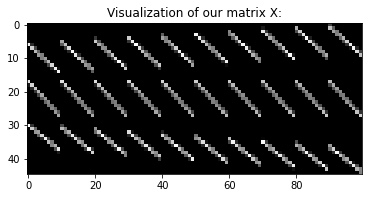

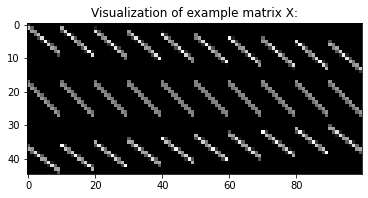

In [67]:
X_sparse_matrix = construct_X(M = 10, alphas = [-33, 1, 42])
X_array = X_sparse_matrix.toarray()

plt.figure()
plt.gray()
plt.imshow(X_array)
plt.title("Visualization of our matrix X:")

X_example = np.load('X_example.npy')

plt.figure()
plt.gray()
plt.imshow(X_example)
plt.title("Visualization of example matrix X:")

equal = (X_array == X_example).all()
print(f"Matrices equal: {equal}\n")


# 5.2 Recovering the image

First, smaller version with M = 77 to make debugging easier. 

In [72]:
# properties of the measurement
M = 77
N_p = 109

# read arrays
y_77 = np.load('y_77.npy')
alphas_77 = np.load('alphas_77.npy')

# calculate X
X_77 = construct_X(M, alphas_77, N_p)

# calculate sparsity
total_elements = X_77.get_shape()[0] * X_77.get_shape()[1]
nonzero_elements = X_77.count_nonzero()
sparsity = (total_elements - nonzero_elements) / total_elements
print(f"X_77 contains {total_elements} elements of which {nonzero_elements} are not zero.")
print(f"This corresponds to a sparsity of {sparsity * 100} %.")

# convert coo_matrix to csc_matrix for solving the linear system efficiently
X_77 = X_77.tocsc()

X_77 contains 58163490 elements of which 1067219 are not zero.
This corresponds to a sparsity of 98.1651393339705 %.


In [83]:
# use the given version of X_77 for now (until construct_x() works properly)
X_77 = np.load('X_77.npy', allow_pickle=True)
X_77 = scipy.sparse.csc_matrix(X_77.all())

In [86]:
# solve equation to get beta (the flattened tomogram) using scipy
# X * beta = y
tolerance = 1e-05
beta_77 = scipy.sparse.linalg.lsqr(X_77, y_77, atol=tolerance, btol=tolerance)[0]
beta_77.shape

(5929,)

254.67113521225235


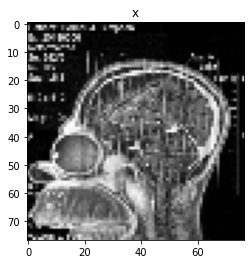

In [85]:
# convert beta to a 2D image
tomogram_77 = beta_77.reshape((M,M))
plt.figure()
plt.gray()
plt.imshow(tomogram_77)
plt.title("Tomogram for measurement with M = 77")

Now, try with the larger version (M = 195).

In [87]:
# properties of the measurement
M = 195
N_p = 275

# read arrays
y_195 = np.load('y_195.npy')
alphas_195 = np.load('alphas_195.npy')

# calculate X
X_195 = construct_X(M, alphas_195, N_p)

# calculate sparsity
total_elements = X_195.get_shape()[0] * X_195.get_shape()[1]
nonzero_elements = X_195.count_nonzero()
sparsity = (total_elements - nonzero_elements) / total_elements
print(f"X_195 contains {total_elements} elements of which {nonzero_elements} are not zero.")
print(f"This corresponds to a sparsity of {sparsity * 100} %.")

# convert coo_matrix to csc_matrix for solving the linear system efficiently
X_195 = X_195.tocsc()

X_195 contains 1871780625 elements of which 13612013 are not zero.
This corresponds to a sparsity of 99.2727773320124 %.


In [88]:
# solve equation to get beta (the flattened tomogram) using scipy
# X * beta = y
tolerance = 1e-05
beta_195 = scipy.sparse.linalg.lsqr(X_195, y_195, atol=tolerance, btol=tolerance)[0]
beta_195.shape

(38025,)

Text(0.5, 1.0, 'Tomogram for measurement with M = 195')

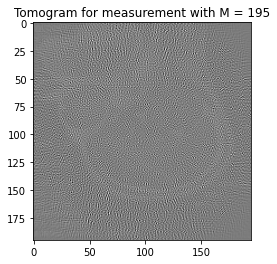

In [89]:
# convert beta to a 2D image
tomogram_195 = beta_195.reshape((M,M))
plt.figure()
plt.gray()
plt.imshow(tomogram_195)
plt.title("Tomogram for measurement with M = 195")

# 5.3 Minimizing the radiation dose